In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_fscore_support, roc_curve, auc, precision_recall_curve, average_precision_score

from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding, TrainerCallback
from datasets import Dataset

from functools import partial
import gc

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_excel('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/News_MBIC/mbic_labeled_dataset.xlsx')
df = df[['sentence', 'Label_bias']]
df.rename(columns={'Label_bias': 'labels'}, inplace=True)
df = df[df['labels']!='No agreement']
class_mapping = {'Biased': 1, 'Non-biased': 0}
df['labels'] = df['labels'].map(class_mapping)
df.head()

,sentence,labels
0,YouTube is making clear there will be no “birt...,1
1,So while there may be a humanitarian crisis dr...,1
2,"Looking around the United States, there is nev...",1
3,The Republican president assumed he was helpin...,1
4,The explosion of the Hispanic population has l...,1


In [6]:
from sklearn.utils.class_weight import compute_class_weight
labels = [label for label in df["labels"].to_list()]
class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0, 1]), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
class_weights

tensor([1.4550, 0.7618])

In [7]:
# Tokenization function
def tokenize_function(examples, input_col, hf_tokenizer):
    tokenized = hf_tokenizer(examples[input_col], truncation=True, max_length=256, padding="max_length")
    return tokenized

# Compute metrics function
def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    pred_labels = np.argmax(eval_pred.predictions, axis=1)

    acc = accuracy_score(labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred_labels, average='binary')
    f1_micro = precision_recall_fscore_support(labels, pred_labels, average='micro')[2]
    f1_weighted_macro = precision_recall_fscore_support(labels, pred_labels, average='weighted')[2]

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "f1_micro": f1_micro,
        "f1_weighted_macro": f1_weighted_macro
    }

# Cleanup function
def cleanup(things_to_delete: list | None = None):
    if things_to_delete is not None:
        for thing in things_to_delete:
            if thing is not None:
                del thing
    gc.collect()
    torch.cuda.empty_cache()

In [8]:
# define custom trainer class: weighted loss
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights).to("cuda" if torch.cuda.is_available() else "cpu")
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [9]:
# Stratified K-Fold training function
def stratified_kfold_finetune(checkpoint: str, output_dir: str, dataset, num_labels: int = 2, weighted:bool=False, do_cleanup: bool = True):
    # Initialize tokenizer
    hf_tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    # Extract data and labels
    texts = dataset["sentence"].to_numpy()
    labels = dataset["labels"].to_numpy()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Metrics storage
    losses, accs, precs, recs, f1s, f1_micros, f1_weighted_macros = [], [], [], [], [], [], []
    best_model = None
    best_tokenizer = None
    best_f1 = 0  # Track best model based on F1-score

    for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
        print(f"Training Fold {fold + 1}")

        # Create fold datasets
        train_data = {"sentence": texts[train_idx].tolist(), "labels": labels[train_idx].tolist()}
        val_data = {"sentence": texts[val_idx].tolist(), "labels": labels[val_idx].tolist()}


        train_dataset = Dataset.from_dict(train_data)
        val_dataset = Dataset.from_dict(val_data)

        # Tokenize
        tokenized_train = train_dataset.map(partial(tokenize_function, input_col="sentence", hf_tokenizer=hf_tokenizer), batched=True)
        tokenized_val = val_dataset.map(partial(tokenize_function, input_col="sentence", hf_tokenizer=hf_tokenizer), batched=True)

        # Initialize model
        hf_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)

        hf_data_collator = DataCollatorWithPadding(tokenizer=hf_tokenizer)

        # Define training arguments
        training_args = TrainingArguments(
            output_dir=f"{output_dir}/fold_{fold}",
            save_total_limit=1,
            learning_rate=2e-5,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            gradient_accumulation_steps=4,
            num_train_epochs=10,
            lr_scheduler_type="linear",
            optim="adamw_torch",
            logging_strategy="epoch",
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            push_to_hub=False,
            report_to="none"
        )

        # Initialize trainer
        if weighted:
            trainer = CustomTrainer(
            model=hf_model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_val,
            tokenizer=hf_tokenizer,
            compute_metrics=compute_metrics,
            data_collator=hf_data_collator,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        )
        else:
          trainer = Trainer(
              model=hf_model,
              args=training_args,
              train_dataset=tokenized_train,
              eval_dataset=tokenized_val,
              tokenizer=hf_tokenizer,
              compute_metrics=compute_metrics,
              data_collator=hf_data_collator,
              callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
          )

        # Train model
        trainer.train()

        # Evaluate on validation set
        eval_results = trainer.evaluate(tokenized_val)

        # Store metrics
        losses.append(eval_results["eval_loss"])
        accs.append(eval_results["eval_accuracy"])
        precs.append(eval_results["eval_precision"])
        recs.append(eval_results["eval_recall"])
        f1s.append(eval_results["eval_f1"])
        f1_micros.append(eval_results["eval_f1_micro"])
        f1_weighted_macros.append(eval_results["eval_f1_weighted_macro"])

        # Keep track of the best model based on F1-score
        if eval_results["eval_f1"] > best_f1:
            best_f1 = eval_results["eval_f1"]
            best_model = hf_model
            best_tokenizer = hf_tokenizer

        # Cleanup to free memory
        if do_cleanup:
            cleanup(things_to_delete=[trainer, hf_model, tokenized_train, tokenized_val, train_dataset, val_dataset])

    # Aggregate results across folds
    loss_cv = np.mean(losses)
    acc_cv = np.mean(accs)
    prec_cv = np.mean(precs)
    rec_cv = np.mean(recs)
    f1_cv = np.mean(f1s)
    f1_micro_cv = np.mean(f1_micros)
    f1_wmacro_cv = np.mean(f1_weighted_macros)

    print('5-Fold CV Loss: {}'.format(loss_cv))
    print('5-Fold CV Accuracy: {}'.format(acc_cv))
    print('5-Fold CV Precision: {}'.format(prec_cv))
    print('5-Fold CV Recall: {}'.format(rec_cv))
    print('5-Fold CV F1 Score: {}'.format(f1_cv))
    print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
    print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

    return {
        "loss": loss_cv,
        "accuracy": acc_cv,
        "precision": prec_cv,
        "recall": rec_cv,
        "f1": f1_cv,
        "f1_micro": f1_micro_cv,
        "f1_weighted_macro": f1_wmacro_cv
    }, best_model, best_tokenizer


# BERT

In [ ]:
checkpoint = "bert-base-uncased"
output_dir = "./bert_finetuned" # saving only best model in drive for inference
metrics, best_model, best_tokenizer = stratified_kfold_finetune(checkpoint, output_dir, df)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Training Fold 1


Map:   0%|          | 0/1240 [00:00<?, ? examples/s]

Map:   0%|          | 0/311 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.575400,0.581205,0.668810,0.904000,0.553922,0.686930,0.668810,0.673696
2,0.460400,0.454791,0.803859,0.806867,0.921569,0.860412,0.803859,0.794993
3,0.313400,0.434890,0.823151,0.863415,0.867647,0.865526,0.823151,0.822952
4,0.190200,0.542037,0.774920,0.868132,0.774510,0.818653,0.774920,0.778996
5,0.126000,0.525481,0.803859,0.835681,0.872549,0.853717,0.803859,0.801670
6,0.097600,0.694684,0.752412,0.884848,0.715686,0.791328,0.752412,0.758411


Training Fold 2


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.557700,0.545564,0.706452,0.879195,0.642157,0.742210,0.706452,0.713817
2,0.385300,0.542151,0.735484,0.842697,0.735294,0.785340,0.735484,0.740930
3,0.239100,0.620749,0.748387,0.879518,0.715686,0.789189,0.748387,0.754589
4,0.133200,0.693199,0.751613,0.829016,0.784314,0.806045,0.751613,0.754298
5,0.069800,0.875331,0.751613,0.819095,0.799020,0.808933,0.751613,0.752934


Training Fold 3


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.540400,0.490614,0.758065,0.830769,0.794118,0.812030,0.758065,0.760262
2,0.374100,0.498446,0.777419,0.808219,0.867647,0.836879,0.777419,0.772892
3,0.240200,0.557814,0.761290,0.831633,0.799020,0.815000,0.761290,0.763243
4,0.139800,0.678650,0.783871,0.812785,0.872549,0.841608,0.783871,0.779475


Training Fold 4


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.575200,0.551915,0.693548,0.880282,0.615764,0.724638,0.693548,0.700445
2,0.443700,0.452273,0.793548,0.871658,0.802956,0.835897,0.793548,0.796494
3,0.318800,0.476151,0.780645,0.877095,0.773399,0.821990,0.780645,0.784814
4,0.205600,0.585157,0.754839,0.894410,0.709360,0.791209,0.754839,0.760806
5,0.122100,0.649772,0.774194,0.875706,0.763547,0.815789,0.774194,0.778700


Training Fold 5


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.560000,0.442038,0.819355,0.858537,0.866995,0.862745,0.819355,0.818945
2,0.407000,0.428501,0.806452,0.890710,0.802956,0.844560,0.806452,0.809709
3,0.277600,0.429760,0.822581,0.830357,0.916256,0.871194,0.822581,0.817291
4,0.163100,0.447402,0.829032,0.857143,0.886700,0.871671,0.829032,0.827590
5,0.107800,0.519506,0.819355,0.880829,0.837438,0.858586,0.819355,0.821106


5-Fold CV Loss: 0.46968567967414854
5-Fold CV Accuracy: 0.7833399024997407
5-Fold CV Precision: 0.8598497261306823
5-Fold CV Recall: 0.8005940307157345
5-Fold CV F1 Score: 0.8286706166170795
5-Fold CV Micro F1 Score: 0.7833399024997407
5-Fold CV Weighted Macro F1 Score: 0.786069575613854


In [ ]:
metrics

{'loss': 0.46968567967414854,
 'accuracy': 0.7833399024997407,
 'precision': 0.8598497261306823,
 'recall': 0.8005940307157345,
 'f1': 0.8286706166170795,
 'f1_micro': 0.7833399024997407,
 'f1_weighted_macro': 0.786069575613854}

In [ ]:
best_model.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/BERT')
best_tokenizer.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/BERT')

('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/BERT/tokenizer_config.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/BERT/special_tokens_map.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/BERT/vocab.txt',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/BERT/added_tokens.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/BERT/tokenizer.json')

In [ ]:
del best_model, best_tokenizer


# BERT-Weighted

In [ ]:
checkpoint = "bert-base-uncased"
output_dir = "./bert_finetuned_weighted" # saving only best model in drive for inference
metrics, best_model, best_tokenizer = stratified_kfold_finetune(checkpoint, output_dir, df, weighted=True,)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Training Fold 1


Map:   0%|          | 0/1240 [00:00<?, ? examples/s]

Map:   0%|          | 0/311 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.596000,0.543237,0.733119,0.895425,0.671569,0.767507,0.733119,0.739737
2,0.417600,0.432063,0.800643,0.865979,0.823529,0.844221,0.800643,0.802589
3,0.250700,0.492243,0.794212,0.906977,0.764706,0.829787,0.794212,0.798840
4,0.151600,0.538487,0.832797,0.845455,0.911765,0.877358,0.832797,0.829197
5,0.069400,0.617438,0.816720,0.876923,0.838235,0.857143,0.816720,0.818352


Training Fold 2


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.604000,0.547397,0.738710,0.825397,0.764706,0.793893,0.738710,0.742356
2,0.446600,0.534172,0.774194,0.860215,0.784314,0.820513,0.774194,0.777819
3,0.298500,0.575904,0.745161,0.853107,0.740196,0.792651,0.745161,0.750526
4,0.211600,0.628851,0.761290,0.825000,0.808824,0.816832,0.761290,0.762319
5,0.118300,0.673821,0.764516,0.832487,0.803922,0.817955,0.764516,0.766224


Training Fold 3


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.589900,0.563195,0.696774,0.835366,0.671569,0.744565,0.696774,0.704360
2,0.392800,0.509317,0.787097,0.845000,0.828431,0.836634,0.787097,0.788014
3,0.248600,0.528049,0.774194,0.825243,0.833333,0.829268,0.774194,0.773669
4,0.128400,0.685048,0.787097,0.819444,0.867647,0.842857,0.787097,0.783751
5,0.079600,0.773683,0.777419,0.802691,0.877451,0.838407,0.777419,0.771415


Training Fold 4


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.618700,0.591480,0.700000,0.857143,0.650246,0.739496,0.700000,0.707359
2,0.457300,0.482436,0.783871,0.857895,0.802956,0.829517,0.783871,0.786485
3,0.297600,0.591122,0.745161,0.892405,0.694581,0.781163,0.745161,0.751416
4,0.205400,0.812635,0.719355,0.926471,0.620690,0.743363,0.719355,0.725079
5,0.142200,0.686313,0.767742,0.857923,0.773399,0.813472,0.767742,0.771650


Training Fold 5


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.593900,0.490244,0.774194,0.898204,0.738916,0.810811,0.774194,0.779466
2,0.415200,0.569387,0.709677,0.924812,0.605911,0.732143,0.709677,0.715215
3,0.287200,0.406990,0.848387,0.886139,0.881773,0.883951,0.848387,0.848553
4,0.159200,0.450534,0.835484,0.858491,0.896552,0.877108,0.835484,0.833656
5,0.083800,0.586583,0.835484,0.904255,0.837438,0.869565,0.835484,0.837716
6,0.043500,0.692303,0.825806,0.898396,0.827586,0.861538,0.825806,0.828292


5-Fold CV Loss: 0.4729953944683075
5-Fold CV Accuracy: 0.7988382947826989
5-Fold CV Precision: 0.8630455571820465
5-Fold CV Recall: 0.8242007147686662
5-Fold CV F1 Score: 0.8429669492261898
5-Fold CV Micro F1 Score: 0.7988382947826989
5-Fold CV Weighted Macro F1 Score: 0.8006917465583585


In [ ]:
metrics

{'loss': 0.4729953944683075,
 'accuracy': 0.7988382947826989,
 'precision': 0.8630455571820465,
 'recall': 0.8242007147686662,
 'f1': 0.8429669492261898,
 'f1_micro': 0.7988382947826989,
 'f1_weighted_macro': 0.8006917465583585}

In [ ]:
best_model.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/BERT_Weighted')
best_tokenizer.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/BERT_Weighted')

('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/BERT_Weighted/tokenizer_config.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/BERT_Weighted/special_tokens_map.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/BERT_Weighted/vocab.txt',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/BERT_Weighted/added_tokens.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/BERT_Weighted/tokenizer.json')

In [ ]:
del best_model,best_tokenizer

# RoBERTa

In [ ]:
checkpoint = "FacebookAI/roberta-base"
output_dir = "./roberta_ft" # saving only best model in drive for inference
metrics, best_model, best_tokenizer = stratified_kfold_finetune(checkpoint, output_dir, df, weighted=True )

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Training Fold 1


Map:   0%|          | 0/1240 [00:00<?, ? examples/s]

Map:   0%|          | 0/311 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.654600,0.572209,0.720257,0.939850,0.612745,0.741840,0.720257,0.725634
2,0.486100,0.412144,0.819936,0.821739,0.926471,0.870968,0.819936,0.812878
3,0.346200,0.448780,0.771704,0.884393,0.750000,0.811671,0.771704,0.776761
4,0.216000,0.455744,0.800643,0.862245,0.828431,0.845000,0.800643,0.802242
5,0.122400,0.570206,0.823151,0.886010,0.838235,0.861461,0.823151,0.825024


Training Fold 2


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.636400,0.460566,0.780645,0.803571,0.882353,0.841121,0.780645,0.774346
2,0.471700,0.487481,0.783871,0.936306,0.720588,0.814404,0.783871,0.789412
3,0.303000,0.462650,0.793548,0.884615,0.789216,0.834197,0.793548,0.797370
4,0.204500,0.609423,0.761290,0.857143,0.764706,0.808290,0.761290,0.765709


Training Fold 3


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.622200,0.512320,0.751613,0.835979,0.774510,0.804071,0.751613,0.755079
2,0.444500,0.508574,0.754839,0.867816,0.740196,0.798942,0.754839,0.760306
3,0.315200,0.467182,0.816129,0.858537,0.862745,0.860636,0.816129,0.815918
4,0.182600,0.607688,0.812903,0.841121,0.882353,0.861244,0.812903,0.810510
5,0.144300,0.773563,0.806452,0.842857,0.867647,0.855072,0.806452,0.805035
6,0.101600,0.821438,0.806452,0.849515,0.857843,0.853659,0.806452,0.806002


Training Fold 4


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.646100,0.537412,0.703226,0.899281,0.615764,0.730994,0.703226,0.709619
2,0.525800,0.436327,0.809677,0.878947,0.822660,0.849873,0.809677,0.811979
3,0.328700,0.468030,0.825806,0.870647,0.862069,0.866337,0.825806,0.826182
4,0.222600,0.657104,0.793548,0.892655,0.778325,0.831579,0.793548,0.797668
5,0.147400,0.746814,0.800000,0.902857,0.778325,0.835979,0.800000,0.804163


Training Fold 5


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.641700,0.484829,0.722581,0.914894,0.635468,0.750000,0.722581,0.728740
2,0.494300,0.478892,0.783871,0.925000,0.729064,0.815427,0.783871,0.789151
3,0.351900,0.362261,0.838710,0.892308,0.857143,0.874372,0.838710,0.839995
4,0.207400,0.461869,0.845161,0.889447,0.871921,0.880597,0.845161,0.845811
5,0.140900,0.462258,0.848387,0.906250,0.857143,0.881013,0.848387,0.849982
6,0.085500,0.830587,0.803226,0.938272,0.748768,0.832877,0.803226,0.807993


5-Fold CV Loss: 0.4276959300041199
5-Fold CV Accuracy: 0.8130193963281818
5-Fold CV Precision: 0.851020441020162
5-Fold CV Recall: 0.870274316623201
5-Fold CV F1 Score: 0.8593939133834961
5-Fold CV Micro F1 Score: 0.8130193963281818
5-Fold CV Weighted Macro F1 Score: 0.811023173537075


In [ ]:
metrics

{'loss': 0.4276959300041199,
 'accuracy': 0.8130193963281818,
 'precision': 0.851020441020162,
 'recall': 0.870274316623201,
 'f1': 0.8593939133834961,
 'f1_micro': 0.8130193963281818,
 'f1_weighted_macro': 0.811023173537075}

In [ ]:
best_model.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/RoBERTa_Weighted')
best_tokenizer.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/RoBERTa_Weighted')

('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/RoBERTa_Weighted/tokenizer_config.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/RoBERTa_Weighted/special_tokens_map.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/RoBERTa_Weighted/vocab.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/RoBERTa_Weighted/merges.txt',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/RoBERTa_Weighted/added_tokens.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/RoBERTa_Weighted/tokenizer.json')

In [ ]:
del best_model, best_tokenizer

# ModernBERT

In [ ]:
checkpoint = "answerdotai/ModernBERT-base"
output_dir = "./modernbert_ft" # saving only best model in drive for inference
metrics, best_model, best_tokenizer = stratified_kfold_finetune(checkpoint, output_dir, df, weighted=True )

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Training Fold 1


Map:   0%|          | 0/1240 [00:00<?, ? examples/s]

Map:   0%|          | 0/311 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,2.241400,0.501211,0.765273,0.896970,0.725490,0.802168,0.765273,0.770961
2,1.553800,0.493070,0.758842,0.779221,0.882353,0.827586,0.758842,0.748917
3,0.853100,0.663660,0.781350,0.919753,0.730392,0.814208,0.781350,0.786741
4,0.367900,0.733156,0.778135,0.872928,0.774510,0.820779,0.778135,0.782274
5,0.124900,1.137362,0.765273,0.807512,0.843137,0.824940,0.765273,0.762654


Training Fold 2


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,2.375400,0.540573,0.716129,0.908451,0.632353,0.745665,0.716129,0.722812
2,1.564800,0.561420,0.745161,0.943262,0.651961,0.771014,0.745161,0.751084
3,0.946600,0.586349,0.761290,0.891566,0.725490,0.800000,0.761290,0.767174
4,0.383300,0.709387,0.774194,0.801802,0.872549,0.835681,0.774194,0.768489


Training Fold 3


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,2.387900,0.564864,0.716129,0.811828,0.740196,0.774359,0.716129,0.720686
2,1.547200,0.518369,0.745161,0.834225,0.764706,0.797954,0.745161,0.749080
3,0.868900,0.698820,0.758065,0.811594,0.823529,0.817518,0.758065,0.757211
4,0.349000,0.848737,0.741935,0.819588,0.779412,0.798995,0.741935,0.744506
5,0.236800,1.651527,0.780645,0.780992,0.926471,0.847534,0.780645,0.766037


Training Fold 4


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,2.432700,0.490897,0.748387,0.869822,0.724138,0.790323,0.748387,0.754136
2,1.755300,0.417447,0.806452,0.859296,0.842365,0.850746,0.806452,0.807264
3,1.170000,0.467112,0.803226,0.834906,0.871921,0.853012,0.803226,0.801040
4,0.603200,0.576914,0.809677,0.852941,0.857143,0.855037,0.809677,0.809464
5,0.204100,1.072355,0.796774,0.868421,0.812808,0.839695,0.796774,0.799232


Training Fold 5


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,2.357000,0.629483,0.661290,0.937500,0.517241,0.666667,0.661290,0.662894
2,1.655700,0.476992,0.800000,0.893855,0.788177,0.837696,0.800000,0.803801
3,0.996800,0.498114,0.822581,0.881443,0.842365,0.861461,0.822581,0.824150
4,0.419100,0.865440,0.806452,0.806867,0.926108,0.862385,0.806452,0.797332
5,0.203600,0.991078,0.780645,0.835821,0.827586,0.831683,0.780645,0.781118


5-Fold CV Loss: 0.4892901360988617
5-Fold CV Accuracy: 0.7653168758427549
5-Fold CV Precision: 0.855009462678405
5-Fold CV Recall: 0.781990727325413
5-Fold CV F1 Score: 0.8119295029421136
5-Fold CV Micro F1 Score: 0.7653168758427549
5-Fold CV Weighted Macro F1 Score: 0.7663750470623913


In [ ]:
metrics

{'loss': 0.4892901360988617,
 'accuracy': 0.7653168758427549,
 'precision': 0.855009462678405,
 'recall': 0.781990727325413,
 'f1': 0.8119295029421136,
 'f1_micro': 0.7653168758427549,
 'f1_weighted_macro': 0.7663750470623913}

In [ ]:
best_model.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/ModernBERT_Weighted')
best_tokenizer.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/ModernBERT_Weighted')

('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/ModernBERT_Weighted/tokenizer_config.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/ModernBERT_Weighted/special_tokens_map.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/ModernBERT_Weighted/tokenizer.json')

In [ ]:
del best_model, best_tokenizer

# DistilBERT

In [ ]:
checkpoint = "distilbert-base-uncased"
output_dir = "./distilbert_ft" # saving only best model in drive for inference
metrics, best_model, best_tokenizer = stratified_kfold_finetune(checkpoint, output_dir, df, weighted=True )

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Training Fold 1


Map:   0%|          | 0/1240 [00:00<?, ? examples/s]

Map:   0%|          | 0/311 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.624800,0.571861,0.720257,0.903448,0.642157,0.750716,0.720257,0.726840
2,0.449100,0.440804,0.803859,0.848780,0.852941,0.850856,0.803859,0.803638
3,0.300400,0.454591,0.794212,0.860825,0.818627,0.839196,0.794212,0.796220
4,0.193600,0.510606,0.790997,0.839024,0.843137,0.841076,0.790997,0.790762
5,0.113700,0.573010,0.803859,0.874346,0.818627,0.845570,0.803859,0.806247


Training Fold 2


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.628400,0.614839,0.677419,0.876812,0.593137,0.707602,0.677419,0.684585
2,0.447500,0.577848,0.722581,0.873418,0.676471,0.762431,0.722581,0.729686
3,0.319000,0.559288,0.735484,0.854651,0.720588,0.781915,0.735484,0.741573
4,0.206600,0.593872,0.774194,0.845361,0.803922,0.824121,0.774194,0.776443
5,0.130100,0.692098,0.754839,0.863636,0.745098,0.800000,0.754839,0.760108
6,0.075100,0.819489,0.758065,0.856354,0.759804,0.805195,0.758065,0.762677


Training Fold 3


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.643800,0.607807,0.661290,0.851064,0.588235,0.695652,0.661290,0.669162
2,0.464800,0.549980,0.725806,0.836158,0.725490,0.776903,0.725806,0.731579
3,0.329600,0.537351,0.751613,0.843243,0.764706,0.802057,0.751613,0.755762
4,0.227500,0.587915,0.761290,0.782609,0.882353,0.829493,0.761290,0.751757
5,0.134900,0.667477,0.758065,0.781659,0.877451,0.826790,0.758065,0.748877
6,0.085000,0.745750,0.767742,0.833333,0.808824,0.820896,0.767742,0.769205


Training Fold 4


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.645400,0.554359,0.729032,0.869565,0.689655,0.769231,0.729032,0.735627
2,0.484800,0.468166,0.803226,0.877660,0.812808,0.843990,0.803226,0.805896
3,0.348700,0.483144,0.803226,0.885870,0.802956,0.842377,0.803226,0.806418
4,0.223000,0.501125,0.796774,0.872340,0.807882,0.838875,0.796774,0.799532
5,0.144500,0.611233,0.783871,0.900000,0.753695,0.820375,0.783871,0.788748


Training Fold 5


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.629700,0.614643,0.677419,0.947826,0.536946,0.685535,0.677419,0.679784
2,0.463300,0.466814,0.787097,0.910180,0.748768,0.821622,0.787097,0.792068
3,0.344200,0.368108,0.845161,0.870813,0.896552,0.883495,0.845161,0.844056
4,0.219300,0.403694,0.848387,0.897959,0.866995,0.882206,0.848387,0.849458
5,0.117500,0.497312,0.822581,0.911111,0.807882,0.856397,0.822581,0.825862
6,0.076300,0.542600,0.822581,0.915730,0.802956,0.855643,0.822581,0.826039


5-Fold CV Loss: 0.4747434318065643
5-Fold CV Accuracy: 0.7878684783736126
5-Fold CV Precision: 0.8590295730872182
5-Fold CV Recall: 0.8095189800057954
5-Fold CV F1 Score: 0.8324624220120512
5-Fold CV Micro F1 Score: 0.7878684783736126
5-Fold CV Weighted Macro F1 Score: 0.7901848902712891


In [ ]:
metrics

{'loss': 0.4747434318065643,
 'accuracy': 0.7878684783736126,
 'precision': 0.8590295730872182,
 'recall': 0.8095189800057954,
 'f1': 0.8324624220120512,
 'f1_micro': 0.7878684783736126,
 'f1_weighted_macro': 0.7901848902712891}

In [ ]:
best_model.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/DistilBERT_Weighted')
best_tokenizer.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/DistilBERT_Weighted')

('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/DistilBERT_Weighted/tokenizer_config.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/DistilBERT_Weighted/special_tokens_map.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/DistilBERT_Weighted/vocab.txt',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/DistilBERT_Weighted/added_tokens.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/DistilBERT_Weighted/tokenizer.json')

In [ ]:
del best_model, best_tokenizer

# DeBERTa-v3-base

In [ ]:
checkpoint = "microsoft/deberta-v3-base"
output_dir = "./deberta_v3_base_ft" # saving only best model in drive for inference
metrics, best_model, best_tokenizer = stratified_kfold_finetune(checkpoint, output_dir, df, weighted=True )

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Training Fold 1


Map:   0%|          | 0/1240 [00:00<?, ? examples/s]

Map:   0%|          | 0/311 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.630800,0.565069,0.704180,0.974576,0.563725,0.714286,0.704180,0.707077
2,0.450200,0.376007,0.842444,0.853881,0.916667,0.884161,0.842444,0.839299
3,0.322800,0.424032,0.807074,0.923529,0.769608,0.839572,0.807074,0.811529
4,0.201700,0.392638,0.861736,0.896552,0.892157,0.894349,0.861736,0.861888
5,0.116200,0.540385,0.852090,0.903061,0.867647,0.885000,0.852090,0.853276


Training Fold 2


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.654500,0.552582,0.638710,0.942308,0.480392,0.636364,0.638710,0.637958
2,0.531000,0.517167,0.706452,0.937984,0.593137,0.726727,0.706452,0.711750
3,0.349700,0.534233,0.758065,0.905660,0.705882,0.793388,0.758065,0.764250
4,0.242200,0.497392,0.780645,0.895349,0.754902,0.819149,0.780645,0.785695
5,0.127400,0.606247,0.809677,0.871795,0.833333,0.852130,0.809677,0.811406
6,0.083500,0.787156,0.806452,0.815789,0.911765,0.861111,0.806452,0.799474
7,0.056900,0.822162,0.803226,0.859296,0.838235,0.848635,0.803226,0.804272


Training Fold 3


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.634200,0.491437,0.761290,0.891566,0.725490,0.800000,0.761290,0.767174
2,0.455800,0.454496,0.777419,0.872928,0.774510,0.820779,0.777419,0.781663
3,0.302100,0.457730,0.809677,0.857143,0.852941,0.855037,0.809677,0.809890
4,0.198500,0.566036,0.809677,0.875648,0.828431,0.851385,0.809677,0.811735
5,0.093600,0.619505,0.838710,0.873786,0.882353,0.878049,0.838710,0.838335


Training Fold 4


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.652100,0.515275,0.696774,0.909774,0.596059,0.720238,0.696774,0.702558
2,0.576700,0.458703,0.806452,0.874346,0.822660,0.847716,0.806452,0.808643
3,0.361100,0.463807,0.793548,0.888268,0.783251,0.832461,0.793548,0.797472
4,0.254500,0.544984,0.816129,0.888298,0.822660,0.854220,0.816129,0.818624
5,0.160500,0.583274,0.796774,0.888889,0.788177,0.835509,0.796774,0.800533


Training Fold 5


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Micro,F1 Weighted Macro
1,0.640100,0.467939,0.825806,0.825328,0.931034,0.875000,0.825806,0.819003
2,0.540200,0.416694,0.803226,0.917647,0.768473,0.836461,0.803226,0.807666
3,0.393700,0.361015,0.861290,0.877358,0.916256,0.896386,0.861290,0.859750
4,0.246700,0.392645,0.835484,0.880000,0.866995,0.873449,0.835484,0.836009
5,0.127200,0.556665,0.832258,0.891192,0.847291,0.868687,0.832258,0.833884
6,0.087000,0.616097,0.841935,0.909574,0.842365,0.874680,0.841935,0.844080


5-Fold CV Loss: 0.42952237725257875
5-Fold CV Accuracy: 0.813650036303288
5-Fold CV Precision: 0.8747724665695905
5-Fold CV Recall: 0.8369989375060369
5-Fold CV F1 Score: 0.8536380383319798
5-Fold CV Micro F1 Score: 0.813650036303288
5-Fold CV Weighted Macro F1 Score: 0.8150098677256379


In [ ]:
metrics

{'loss': 0.42952237725257875,
 'accuracy': 0.813650036303288,
 'precision': 0.8747724665695905,
 'recall': 0.8369989375060369,
 'f1': 0.8536380383319798,
 'f1_micro': 0.813650036303288,
 'f1_weighted_macro': 0.8150098677256379}

In [ ]:
best_model.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/DeBERTa_Weighted')
best_tokenizer.save_pretrained('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/DeBERTa_Weighted')

('/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/DeBERTa_Weighted/tokenizer_config.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/DeBERTa_Weighted/special_tokens_map.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/DeBERTa_Weighted/spm.model',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/DeBERTa_Weighted/added_tokens.json',
 '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/DeBERTa_Weighted/tokenizer.json')

In [ ]:
del best_model, best_tokenizer

# ROC and Precision-Recall Curves

In [8]:
# Tokenization function
def tokenize_function(examples, input_col, hf_tokenizer):
    tokenized = hf_tokenizer(examples[input_col], truncation=True, max_length=256, padding="max_length")
    return tokenized

In [5]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
test_df = test_df[['sentence', 'labels']]
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)


In [6]:
checkpoint = '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/BERT_Weighted'
bert_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
bert_model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [9]:
tokenized_test = test_dataset.map(partial(tokenize_function, input_col="sentence", hf_tokenizer=bert_tokenizer), batched=True)

Map:   0%|          | 0/156 [00:00<?, ? examples/s]

In [11]:
bert_model.eval()
bert_model.to('cuda')


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Extract labels and predictions
y_true = test_df['labels'].values
tokenized_inputs = {key: torch.tensor(val).to("cuda") for key, val in tokenized_test.to_dict().items() if key not in ["sentence", "labels"]}

with torch.no_grad():
    logits = bert_model(**tokenized_inputs).logits.cpu().numpy()

y_scores = F.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()

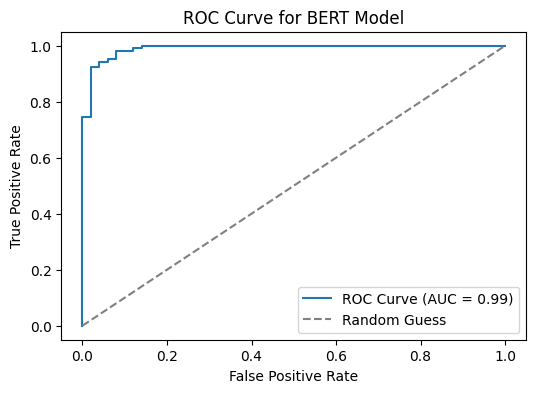

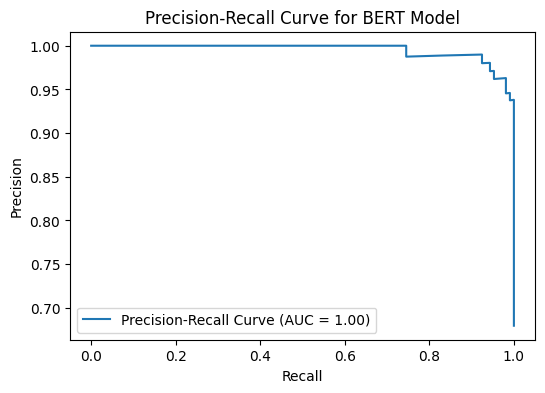

In [14]:
# Compute ROC curve
bert_fpr, bert_tpr, _ = roc_curve(y_true, y_scores)
bert_roc_auc = auc(bert_fpr, bert_tpr)

# Compute Precision-Recall curve
bert_precision, bert_recall, _ = precision_recall_curve(y_true, y_scores)
bert_auc_pr = auc(bert_recall, bert_precision)


# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(bert_fpr, bert_tpr, label=f'ROC Curve (AUC = {bert_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for BERT Model")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(6, 4))
plt.plot(bert_recall, bert_precision, label=f'Precision-Recall Curve (AUC = {bert_auc_pr:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for BERT Model")
plt.legend()
plt.show()


In [15]:
checkpoint = '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/RoBERTa_Weighted'
roberta_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
roberta_model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [16]:
tokenized_test = test_dataset.map(partial(tokenize_function, input_col="sentence", hf_tokenizer=roberta_tokenizer), batched=True)

Map:   0%|          | 0/156 [00:00<?, ? examples/s]

In [17]:
roberta_model.eval()
roberta_model.to('cuda')


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [18]:
# Extract labels and predictions
y_true = test_df['labels'].values
tokenized_inputs = {key: torch.tensor(val).to("cuda") for key, val in tokenized_test.to_dict().items() if key not in ["sentence", "labels"]}

with torch.no_grad():
    logits = roberta_model(**tokenized_inputs).logits.cpu().numpy()

y_scores = F.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()

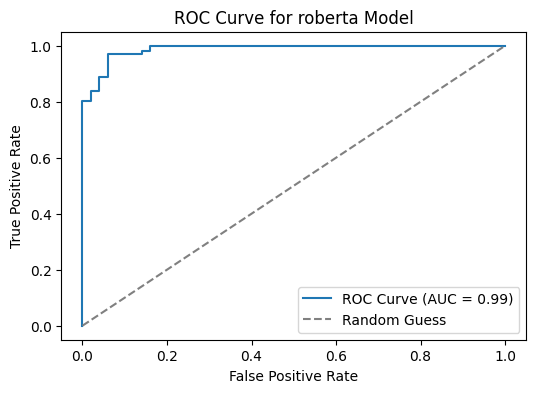

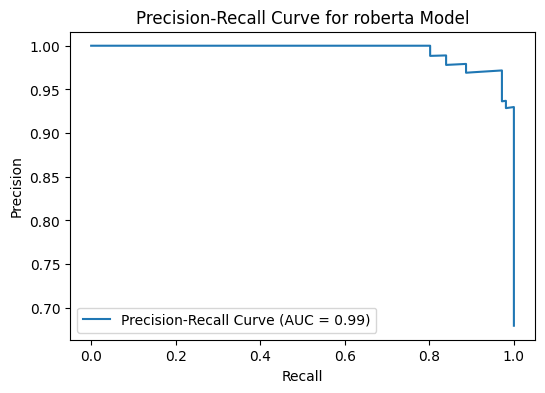

In [19]:
# Compute ROC curve
roberta_fpr, roberta_tpr, _ = roc_curve(y_true, y_scores)
roberta_roc_auc = auc(roberta_fpr, roberta_tpr)

# Compute Precision-Recall curve
roberta_precision, roberta_recall, _ = precision_recall_curve(y_true, y_scores)
roberta_auc_pr = auc(roberta_recall, roberta_precision)


# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(roberta_fpr, roberta_tpr, label=f'ROC Curve (AUC = {roberta_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for roberta Model")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(6, 4))
plt.plot(roberta_recall, roberta_precision, label=f'Precision-Recall Curve (AUC = {roberta_auc_pr:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for roberta Model")
plt.legend()
plt.show()


In [20]:
checkpoint = '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/DistilBERT_Weighted'
distilbert_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
distilbert_model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [21]:
tokenized_test = test_dataset.map(partial(tokenize_function, input_col="sentence", hf_tokenizer=distilbert_tokenizer), batched=True)

Map:   0%|          | 0/156 [00:00<?, ? examples/s]

In [22]:
distilbert_model.eval()
distilbert_model.to('cuda')


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [23]:
# Extract labels and predictions
y_true = test_df['labels'].values
tokenized_inputs = {key: torch.tensor(val).to("cuda") for key, val in tokenized_test.to_dict().items() if key not in ["sentence", "labels"]}

with torch.no_grad():
    logits = distilbert_model(**tokenized_inputs).logits.cpu().numpy()

y_scores = F.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()

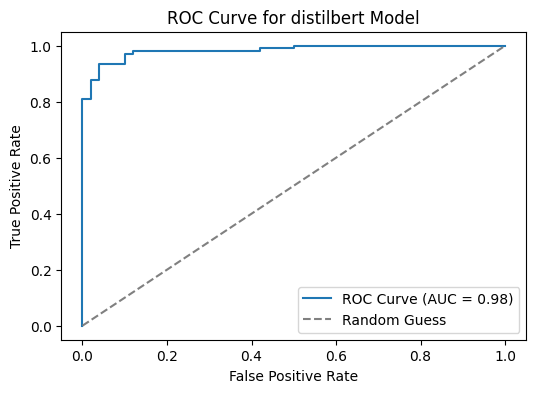

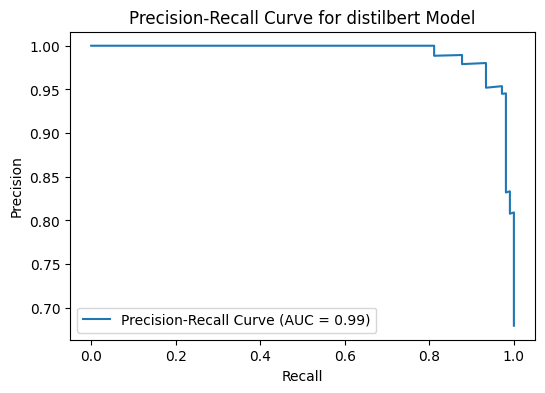

In [24]:
# Compute ROC curve
distilbert_fpr, distilbert_tpr, _ = roc_curve(y_true, y_scores)
distilbert_roc_auc = auc(distilbert_fpr, distilbert_tpr)

# Compute Precision-Recall curve
distilbert_precision, distilbert_recall, _ = precision_recall_curve(y_true, y_scores)
distilbert_auc_pr = auc(distilbert_recall, distilbert_precision)


# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(distilbert_fpr, distilbert_tpr, label=f'ROC Curve (AUC = {distilbert_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for distilbert Model")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(6, 4))
plt.plot(distilbert_recall, distilbert_precision, label=f'Precision-Recall Curve (AUC = {distilbert_auc_pr:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for distilbert Model")
plt.legend()
plt.show()


In [25]:
checkpoint = '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/ModernBERT_Weighted'
modernbert_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
modernbert_model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [26]:
tokenized_test = test_dataset.map(partial(tokenize_function, input_col="sentence", hf_tokenizer=modernbert_tokenizer), batched=True)

Map:   0%|          | 0/156 [00:00<?, ? examples/s]

In [27]:
modernbert_model.eval()
modernbert_model.to('cuda')


ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      

In [28]:
# Extract labels and predictions
y_true = test_df['labels'].values
tokenized_inputs = {key: torch.tensor(val).to("cuda") for key, val in tokenized_test.to_dict().items() if key not in ["sentence", "labels"]}

with torch.no_grad():
    logits = modernbert_model(**tokenized_inputs).logits.cpu().numpy()

y_scores = F.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()

W0331 01:31:46.529000 1898 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


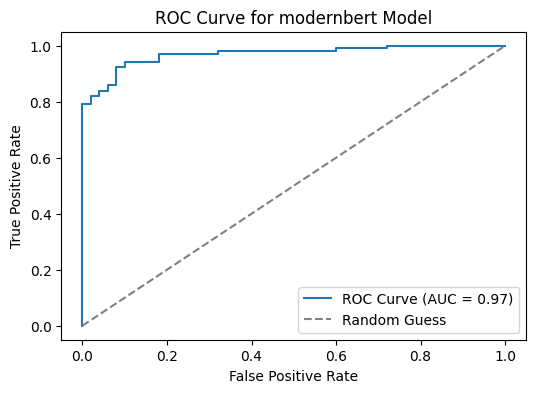

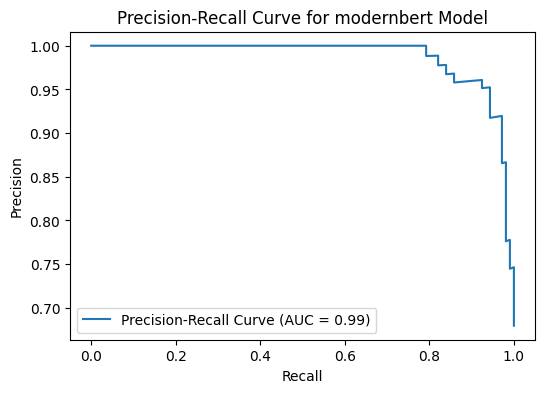

In [29]:
# Compute ROC curve
modernbert_fpr, modernbert_tpr, _ = roc_curve(y_true, y_scores)
modernbert_roc_auc = auc(modernbert_fpr, modernbert_tpr)

# Compute Precision-Recall curve
modernbert_precision, modernbert_recall, _ = precision_recall_curve(y_true, y_scores)
modernbert_auc_pr = auc(modernbert_recall, modernbert_precision)


# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(modernbert_fpr, modernbert_tpr, label=f'ROC Curve (AUC = {modernbert_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for modernbert Model")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(6, 4))
plt.plot(modernbert_recall, modernbert_precision, label=f'Precision-Recall Curve (AUC = {modernbert_auc_pr:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for modernbert Model")
plt.legend()
plt.show()


In [32]:
checkpoint = '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/DeBERTa_Weighted'
deberta_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
deberta_model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [33]:
tokenized_test = test_dataset.map(partial(tokenize_function, input_col="sentence", hf_tokenizer=deberta_tokenizer), batched=True)

Map:   0%|          | 0/156 [00:00<?, ? examples/s]

In [34]:
deberta_model.eval()
deberta_model.to('cuda')


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [35]:
# Extract labels and predictions
y_true = test_df['labels'].values
tokenized_inputs = {key: torch.tensor(val).to("cuda") for key, val in tokenized_test.to_dict().items() if key not in ["sentence", "labels"]}

with torch.no_grad():
    logits = deberta_model(**tokenized_inputs).logits.cpu().numpy()

y_scores = F.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()

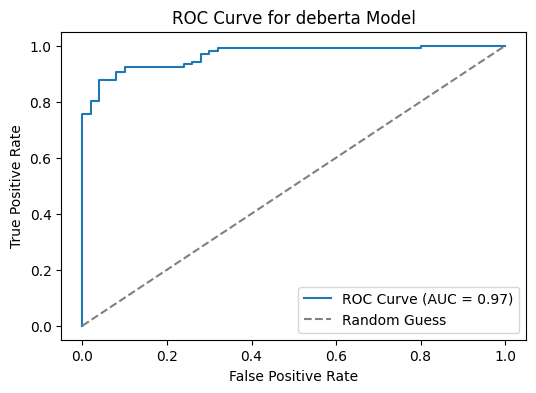

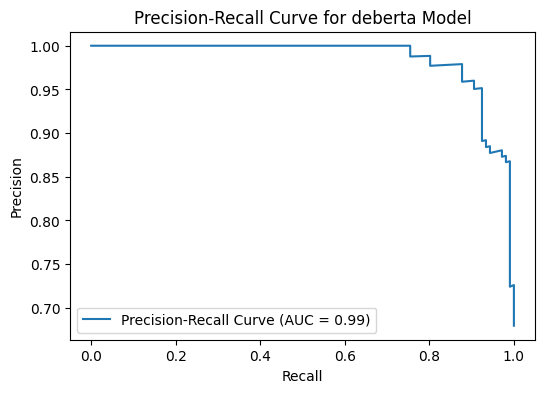

In [36]:
# Compute ROC curve
deberta_fpr, deberta_tpr, _ = roc_curve(y_true, y_scores)
deberta_roc_auc = auc(deberta_fpr, deberta_tpr)

# Compute Precision-Recall curve
deberta_precision, deberta_recall, _ = precision_recall_curve(y_true, y_scores)
deberta_auc_pr = auc(deberta_recall, deberta_precision)


# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(deberta_fpr, deberta_tpr, label=f'ROC Curve (AUC = {deberta_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for deberta Model")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(6, 4))
plt.plot(deberta_recall, deberta_precision, label=f'Precision-Recall Curve (AUC = {deberta_auc_pr:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for deberta Model")
plt.legend()
plt.show()


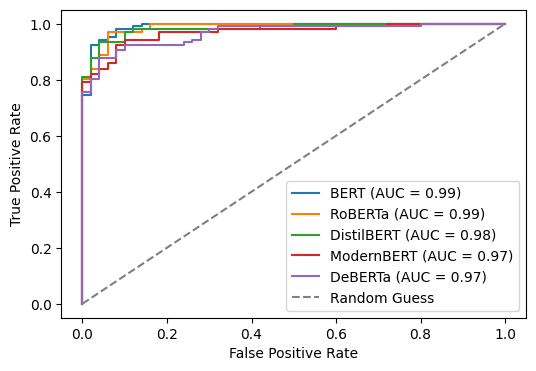

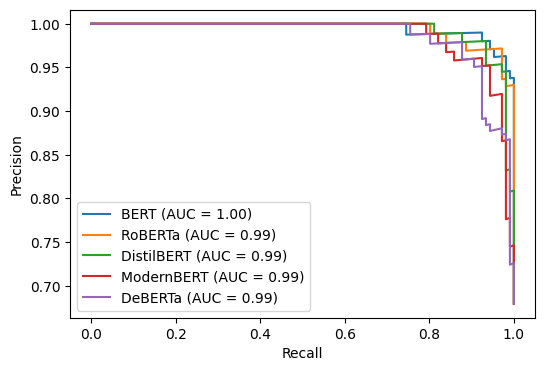

In [38]:
# Plot all together

models_roc_prc = {
    'BERT': (bert_fpr, bert_tpr, bert_roc_auc, bert_precision, bert_recall, bert_auc_pr),
    'RoBERTa': (roberta_fpr, roberta_tpr, roberta_roc_auc, roberta_precision, roberta_recall, roberta_auc_pr),
    'DistilBERT': (distilbert_fpr, distilbert_tpr, distilbert_roc_auc, distilbert_precision, distilbert_recall, distilbert_auc_pr),
    'ModernBERT': (modernbert_fpr, modernbert_tpr, modernbert_roc_auc, modernbert_precision, modernbert_recall, modernbert_auc_pr),
    'DeBERTa': (deberta_fpr, deberta_tpr, deberta_roc_auc, deberta_precision, deberta_recall, deberta_auc_pr)
}


# Plot ROC Curves for all models
plt.figure(figsize=(6, 4))
for model, (fpr, tpr, roc_auc, _, _, _) in models_roc_prc.items():
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("ROC Curves for All Models")
plt.legend()
plt.show()

# Plot Precision-Recall Curves for all models
plt.figure(figsize=(6, 4))
for model, (_, _, _, precision, recall, auc_pr) in models_roc_prc.items():
    plt.plot(recall, precision, label=f'{model} (AUC = {auc_pr:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
# plt.title("Precision-Recall Curves for All Models")
plt.legend()
plt.show()



In [40]:
from transformers import AutoModel
checkpoint = '/content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/RoBERTa_Weighted'
roberta_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
roberta_model = AutoModel.from_pretrained(checkpoint)

tokenized_test = test_dataset.map(partial(tokenize_function, input_col="sentence", hf_tokenizer=roberta_tokenizer), batched=True)
tokenized_inputs = {key: torch.tensor(val).to("cuda") for key, val in tokenized_test.to_dict().items() if key not in ["sentence", "labels"]}

Some weights of RobertaModel were not initialized from the model checkpoint at /content/drive/Shareddrives/FYP 2024-2025/Phase-2/Lexical Bias Detection/News/saved_models/RoBERTa_Weighted and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/156 [00:00<?, ? examples/s]

In [42]:
roberta_model.to("cuda")

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [44]:
import seaborn as sns

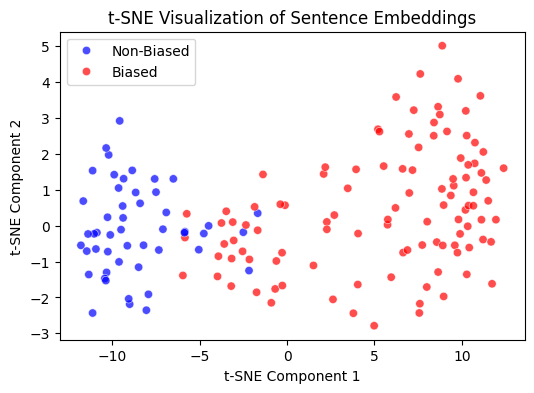

In [50]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Extract embeddings for visualization
with torch.no_grad():
    embeddings = roberta_model(**tokenized_inputs).last_hidden_state[:, 0, :].cpu().numpy()

# Reduce dimensions using PCA and t-SNE
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

# Further reduce dimensions using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

# Plot t-SNE visualization
plt.figure(figsize=(6, 4))
sns.scatterplot(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1], hue=y_true, palette=['blue', 'red'], alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Sentence Embeddings")
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=["Non-Biased", "Biased"])
plt.show()